# Section 0 问题描述与完成项目流程

## 1. 问题描述


<img src="default.png" width="20%"></img>

在该项目中，你将使用强化学习算法，实现一个自动走迷宫机器人。

1. 如上图所示，智能机器人显示在右上角。在我们的迷宫中，有陷阱（红色炸弹）及终点（蓝色的目标点）两种情景。机器人要尽量避开陷阱、尽快到达目的地。
2. 小车可执行的动作包括：向上走 `u`、向右走 `r`、向下走 `d`、向左走 `l`。
3. 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况。
    - 撞到墙壁：-10
    - 走到终点：50
    - 走到陷阱：-30
    - 其余情况：-0.1
4. 我们需要通过修改 `robot.py` 中的代码，来实现一个 Q Learning 机器人，实现上述的目标。

## 2. 完成项目流程

1. 配置环境，使用 `envirnment.yml` 文件配置名为 `robot-env` 的 conda 环境，具体而言，你只需转到当前的目录，在命令行/终端中运行如下代码，稍作等待即可。
```
conda env create -f envirnment.yml
```
安装完毕后，在命令行/终端中运行 `source activate robot-env`（Mac/Linux 系统）或 `activate robot-env`（Windows 系统）激活该环境。

2. 阅读 `main.ipynb` 中的指导完成项目，并根据指导修改对应的代码，生成、观察结果。
3. 导出代码与报告，上传文件，提交审阅并优化。
---

---

# Section 1 算法理解


## 1. 1 强化学习总览

强化学习作为机器学习算法的一种，其模式也是让智能体在“训练”中学到“经验”，以实现给定的任务。但不同于监督学习与非监督学习，在强化学习的框架中，我们更侧重通过智能体与环境的**交互**来学习。通常在监督学习和非监督学习任务中，智能体往往需要通过给定的训练集，辅之以既定的训练目标（如最小化损失函数），通过给定的学习算法来实现这一目标。然而在强化学习中，智能体则是通过其与环境交互得到的奖励进行学习。这个环境可以是虚拟的（如虚拟的迷宫），也可以是真实的（自动驾驶汽车在真实道路上收集数据）。


在强化学习中有五个核心组成部分，它们分别是：**环境（Environment）**、**智能体（Agent）**、**状态（State）**、**动作（Action）**和**奖励（Reward）**。在某一时间节点 $t$：
    
- 智能体在从环境中感知其所处的状态 $s_t$
- 智能体根据某些准则选择动作 $a_t$
- 环境根据智能体选择的动作，向智能体反馈奖励 $r_{t+1}$

通过合理的学习算法，智能体将在这样的问题设置下，成功学到一个在状态 $s_t$ 选择动作 $a_t$ 的策略 $\pi (s_t) = a_t$。

---

**问题 1**：请参照如上的定义，描述出 “机器人走迷宫这个问题” 中强化学习五个组成部分对应的实际对象：

- **环境** : 迷宫 是环境,

迷宫中的主要组成要素有：

（1） 迷宫的大小形状

（2） 迷宫的陷阱数量及所在位置 

（3） 机器人的初始位置和终点位置

（4） 机器人所在当前位置对应的动作的奖励值，决定机器人会如何选择下一步的动作

- **状态** : 撞到墙壁 ，走到终点，走到陷阱，其他情况 这四种状态

包括机器人所处的位置，及该位置对应的每个动作的奖励值，机器人根据当前位置的奖励值选择奖励值最大的那个动作


- **动作** : 向上走 u、向右走 r、向下走 d、向左走 l 这四个动作
- **奖励** : 
对应上面的四种状态分别对应四个奖励值：
撞到墙壁：-10，走到终点：50，走到陷阱：-30，其余情况：-0.1

$$T(s^{'}, a, s) = P(s^{'}|a,s)$$


---

## 1.2 计算 Q 值 

在我们的项目中，我们要实现基于 Q-Learning 的强化学习算法。Q-Learning 是一个值迭代（Value Iteration）算法。与策略迭代（Policy Iteration）算法不同，值迭代算法会计算每个”状态“或是”状态-动作“的值（Value）或是效用（Utility），然后在执行动作的时候，会设法最大化这个值。因此，对每个状态值的准确估计，是我们值迭代算法的核心。通常我们会考虑**最大化动作的长期奖励**，即不仅考虑当前动作带来的奖励，还会考虑动作长远的奖励。

在 Q-Learning 算法中，我们把这个长期奖励记为 Q 值，我们会考虑每个 ”状态-动作“ 的 Q 值，具体而言，它的计算公式为：

$$
q(s_{t},a) = R_{t+1} + \gamma \times\max_a q(a,s_{t+1})
$$

也就是对于当前的“状态-动作” $(s_{t},a)$，我们考虑执行动作 $a$ 后环境给我们的奖励 $R_{t+1}$，以及执行动作 $a$ 到达 $s_{t+1}$后，执行任意动作能够获得的最大的Q值 $\max_a q(a,s_{t+1})$，$\gamma$ 为折扣因子。

不过一般地，我们使用更为保守地更新 Q 表的方法，即引入松弛变量 $alpha$，按如下的公式进行更新，使得 Q 表的迭代变化更为平缓。

$$
q(s_{t},a) = (1-\alpha) \times q(s_{t},a) + \alpha \times(R_{t+1} + \gamma \times\max_a q(a,s_{t+1}))
$$



---
<img src="default2.png" width="20%"></img>

**问题 2**：根据已知条件求 $q(s_{t},a)$，在如下模板代码中的空格填入对应的数字即可。


已知：如上图，机器人位于 $s_1$，行动为 `u`，行动获得的奖励与题目的默认设置相同。在 $s_2$ 中执行各动作的 Q 值为：`u`: -24，`r`: -13，`d`: -0.29、`l`: +40，$\gamma$ 取0.9。


$$
\begin{align}
q(s_{t},a) & = R_{t+1} + \gamma \times\max_a q(a,s_{t+1}) \\
 & =(-0.1) + (0.9)*(40) \\
 & =(35.9)
\end{align}
$$


---

## 1.3 如何选择动作

在强化学习中，「探索-利用」问题是非常重要的问题。具体来说，根据上面的定义，我们会尽可能地让机器人在每次选择最优的决策，来最大化长期奖励。但是这样做有如下的弊端：
1. 在初步的学习中，我们的 Q 值会不准确，如果在这个时候都按照 Q 值来选择，那么会造成错误。
2. 学习一段时间后，机器人的路线会相对固定，则机器人无法对环境进行有效的探索。

因此我们需要一种办法，来解决如上的问题，增加机器人的探索。由此我们考虑使用 epsilon-greedy 算法，即在小车选择动作的时候，以一部分的概率随机选择动作，以一部分的概率按照最优的 Q 值选择动作。同时，这个选择随机动作的概率应当随着训练的过程逐步减小。

---

**问题 3**：在如下的代码块中，实现 epsilon-greedy 算法的逻辑，并运行测试代码。

In [1]:
import random

actions = ['u','r','d','l']
qline = {'u':1.2, 'r':-2.1, 'd':-24.5, 'l':27}
epsilon = 0.3 # 以0.3的概率进行随机选择

def choose_action(epsilon):
    
    action = None
    r = random.random()
    
    print("random:",r)
    if  r < epsilon : # 以某一概率
        action=actions[random.randint(0,3)] # 实现对动作的随机选择
    else: 
        action = max(qline, key=qline.get) # 否则选择具有最大 Q 值的动作
    return action
print(choose_action(epsilon))

random: 0.3298520797992567
l


---

---

# Section 2 代码实现

## 2.1. `Maze` 类理解

我们首先引入了迷宫类 `Maze`，这是一个非常强大的函数，它能够根据你的要求随机创建一个迷宫，或者根据指定的文件，读入一个迷宫地图信息。

1. 使用 `Maze("file_name")` 根据指定文件创建迷宫，或者使用 `Maze(maze_size=(height,width))` 来随机生成一个迷宫。
2. 使用 `trap_number` 参数，在创建迷宫的时候，设定迷宫中陷阱的数量。
3. 直接键入迷宫变量的名字按回车，展示迷宫图像（如 `g=Maze("xx.txt")`，那么直接输入 `g` 即可。
4. 建议生成的迷宫尺寸，长在 6~12 之间，宽在 10～12 之间。

---

**问题 4**：在如下的代码块中，创建你的迷宫并展示。

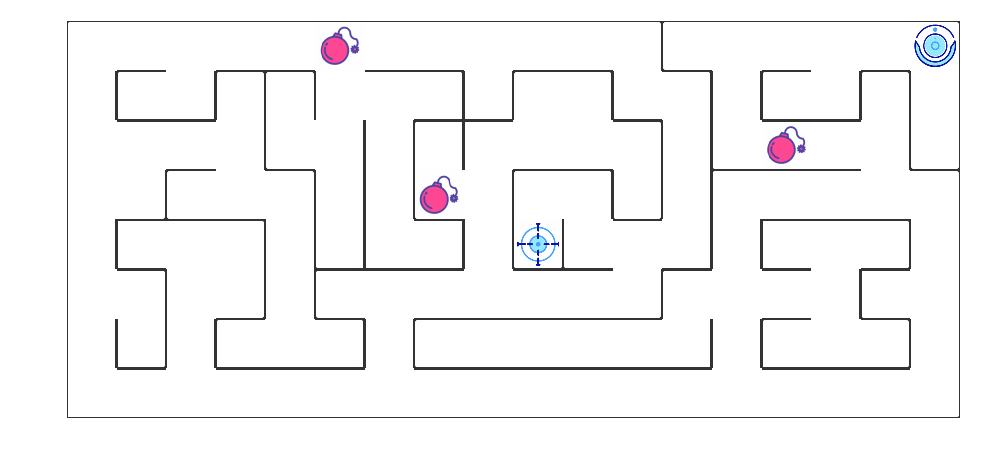

Maze of size (8, 18)

In [2]:
from Maze import Maze
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## todo: 创建迷宫并展示
maze=Maze(maze_size=(8,18),trap_number=3)
maze

---

你可能已经注意到，在迷宫中我们已经默认放置了一个机器人。实际上，我们为迷宫配置了相应的 API，来帮助机器人的移动与感知。其中你随后会使用的两个 API 为 `maze.sense_robot()` 及 `maze.move_robot()`。

1. `maze.sense_robot()` 为一个无参数的函数，输出机器人在迷宫中目前的位置。
2. `maze.move_robot(direction)` 对输入的移动方向，移动机器人，并返回对应动作的奖励值。

---

**问题 5**：随机移动机器人，并记录下获得的奖励，展示出机器人最后的位置。

In [3]:
rewards = []

## 循环、随机移动机器人10次，记录下奖励
for i in range(10):
    m_pos = maze.sense_robot()
    m_reward = maze.move_robot(actions[random.randint(0,3)])
    #print('pos:',m_pos)
    #print('reward:',m_reward)
    
    

## 输出机器人最后的位置
print('robot_position:',m_pos)

## 打印迷宫，观察机器人位置

robot_position: (0, 16)


## 2.2. `Robot` 类实现

`Robot` 类是我们需要重点实现的部分。在这个类中，我们需要实现诸多功能，以使得我们成功实现一个强化学习智能体。总体来说，之前我们是人为地在环境中移动了机器人，但是现在通过实现 `Robot` 这个类，机器人将会自己移动。通过实现学习函数，`Robot` 类将会学习到如何选择最优的动作，并且更新强化学习中对应的参数。

首先 `Robot` 有多个输入，其中 `alpha=0.5, gamma=0.9, epsilon0=0.5` 表征强化学习相关的各个参数的默认值，这些在之前你已经了解到，`Maze` 应为机器人所在迷宫对象。

随后观察 `Robot.update` 函数，它指明了在每次执行动作时，`Robot` 需要执行的程序。按照这些程序，各个函数的功能也就明了了。

最后你需要实现 `Robot.py` 代码中的8段代码，他们都在代码中以 `#TODO` 进行标注，你能轻松地找到他们。

---

**问题 6**：实现 `Robot.py` 中的8段代码，并运行如下代码检查效果（记得将 `maze` 变量修改为你创建迷宫的变量名）。



create_Qtable_line (0, 16)
create_Qtable_line {}
state: (0, 16)
create_Qtable_line (0, 16)
create_Qtable_line {(0, 16): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action:random_choose
****************action ***************************** u
-10.0
next_state: (0, 16)
create_Qtable_line (0, 16)
create_Qtable_line {(0, 16): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 16): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 16)
update_Qtable:action u
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -9.5, 'r': 0.0, 'd': 0.0, 'l': 0.0}
('u', -10.0)


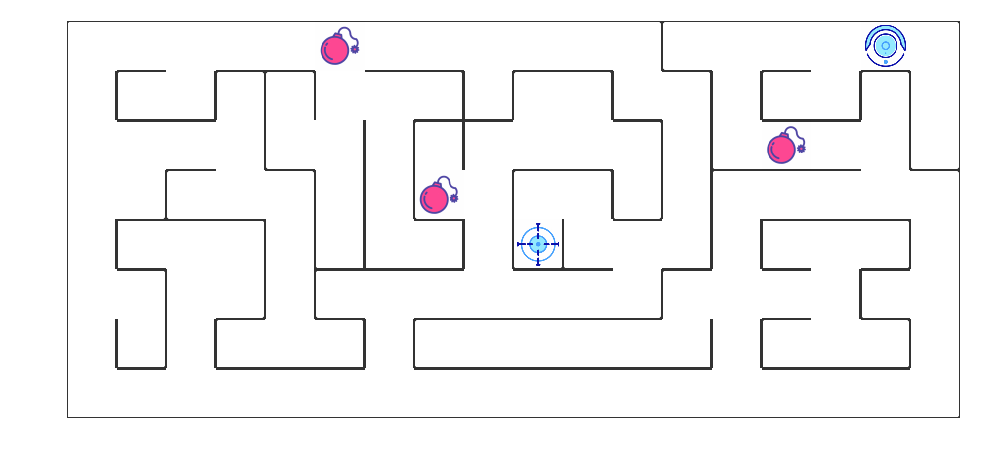

Maze of size (8, 18)

In [4]:
from Robot import Robot
robot = Robot(maze) # 记得将 maze 变量修改为你创建迷宫的变量名
robot.set_status(learning=True,testing=False)
print(robot.update())

maze

---

## 2.3 用 `Runner` 类训练 Robot

在实现了上述内容之后，我们就可以开始对我们 `Robot` 进行训练并调参了。我们为你准备了又一个非常棒的类 `Runner`，来实现整个训练过程及可视化。使用如下的代码，你可以成功对机器人进行训练。并且你会在当前文件夹中生成一个名为 `filename` 的视频，记录了整个训练的过程。通过观察该视频，你能够发现训练过程中的问题，并且优化你的代码及参数。

---

**问题 7**：尝试利用下列代码训练机器人，并进行调参。可选的参数包括：

- 训练参数
    - 训练次数 `epoch`
- 机器人参数：
    - `epsilon0` (epsilon 初值)
    - `epsilon`衰减（可以是线性、指数衰减，可以调整衰减的速度），你需要在 Robot.py 中调整
    - `alpha`
    - `gamma`
- 迷宫参数:
    - 迷宫大小
    - 迷宫中陷阱的数量

In [60]:
## 可选的参数：
epoch = 20
epsilon0 = 0.3
alpha = 0.6
gamma = 0.9

maze_size = (6,6)
trap_number = 1

In [61]:
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)
runner.generate_movie(filename = "final1.mp4") # 你可以注释该行代码，加快运行速度，不过你就无法观察到视频了。

create_Qtable_line (0, 5)
create_Qtable_line {}
state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest u
****************action ***************************** u
-10.0
next_state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 5)
update_Qtable:action u
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -11.4, 'r': 0.0, 'd': 0.0, 'l': 0.0}
state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action:random_choose
****************action ***************************** l
-0.1
next_state: (0, 4)
create_Qtable_line (0, 4)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -11.4, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 4): {'u': 0.0, 'r': 0.0, 'd': 0.0, '

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.1596}, (0, 4): {'u': -11.4, 'r': -0.11399999999999999, 'd': 0.0, 'l': 0.0}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (1, 4)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -11.4, 'r': -0.11399999999999999, 'd': -0.11399999999999999, 'l': 0.0}
state: (1, 4)
create_Qtable_line (1, 4)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.1596}, (0, 4): {'u': -11.4, 'r': -0.11399999999999999, 'd': -0.11399999999999999, 'l': 0.0}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest u
****************action ***************************** u
-0.1
next_state: (0, 4)
create_Qtable_line (0, 4)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.19999

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.1596}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.11399999999999999, 'l': -0.11399999999999999}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.11399999999999999, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.1596}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.11399999999999999, 'l': -0.11399999999999999}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.11399999999999999, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 4)
update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}
state: (0, 4)
create_Qtable_line (0, 4)
cre

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.11399999999999999}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.11399999999999999, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}, (1, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 3)
update_Qtable:action u
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.11399999999999999, 'r': 0.0, 'd': 0.0, 'l': 0.0}
state: (0, 3)
create_Qtable_line (0, 3)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.11399999999999999}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.11399999999999999, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.11399999999999999, 'l': 0.0}, (1, 3): {'u': -0.11399999999999999, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 2)
create_Qtable_line (0, 2)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.11399

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.1596, 'l': -0.11399999999999999}, (1, 3): {'u': -0.11399999999999999, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}, (0, 2): {'u': -11.4, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}}
choose_action highest d
****************action ***************************** d
-0.1
next_state: (2, 3)
create_Qtable_line (2, 3)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.1596, 'l': -0.11399999999999999}, (1, 3): {'u': -0.11399999999999999, 'r': -0.16940400000000003, 'd': -0.11399999999999999, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}, (2, 3): {'u': -0.11399999999999999, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 3)
update_Qtable:action u
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': -0.11399999999999999, 'l': -11.4}
state: (0, 3)
create_Qtable_line (0, 3)
create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.1596, 'l': -0.1596}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': -0.11399999999999999, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.16940400000000003, 'd': -11.4, 'l': -0.1596}, (2, 3): {'u': -0.11399999999999999, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.16940400000000003, 'd': -11.4, 'l': 0.0}}
next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, '

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.1596, 'l': -0.1596}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': -0.11399999999999999, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.16940400000000003, 'd': -11.4, 'l': -0.1596}, (2, 3): {'u': -0.11399999999999999, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.16940400000000003, 'd': -11.4, 'l': -0.11399999999999999}, (0, 0): {'u': -11.4, 'r': -0.16940400000000003, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.11399999999999999}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.1596, 'l': -0.1596}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': -0.11399999999999999, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.16940400000000003, 'd': -11.4, 'l': -0.1596}, (2, 3): {'u': -0.11399999999999999, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.16940400000000003, 'd': -11.4, 'l': -0.1596}, (0, 0): {'u': -11.4, 'r': -0.16940400000000003, 'd': -11.4, 'l': -11.4}}
next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.233244}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.1596, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.2848632}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.233244, 'l': -0.1596}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.2371656}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.233244, 'l': -0.1596}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 27.524160000000002, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.25932720000000004, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 79.8, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 4)
create_Qtable_line (0, 4)
create_Qtable_line {(0, 5): {'u': -11.4

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.30551088}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.233244, 'l': -0.2554056}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.2371656}, (0, 3): {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.233244, 'l': -0.1596}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 27.524160000000002, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.25932720000000004, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 79.8, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 2)
update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -11.4, 'r': -0.16940400000000003, 'd': -0.233244, 'l

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.30551088}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.233244, 'l': -0.2554056}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.21500400000000003, 'r': -11.4, 'd': -11.4, 'l': -0.2371656}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': -0.233244, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 27.524160000000002, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 79.8, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.30551088}, (0, 4): {'u': -11.4, 'r': -0.2371656, 'd': -0.233244, 'l': -0.2554056}, (1, 5): {'

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.30551088}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.31178954400000003, 'l': -0.2554056}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': -0.2371656}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': -0.233244, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 27.524160000000002, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 79.8, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 4)
create_Qtable_line (0, 4)
create_Qtable_line {(0, 5): {'u

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.36033147360000006}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.31178954400000003, 'l': -0.329518824}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': -0.2371656}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': -0.233244, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 27.524160000000002, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 79.8, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (1, 3)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -11.4, 'r': -0.295118184, 'd': 13.169

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.36033147360000006}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.31178954400000003, 'l': -0.329518824}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': -0.2371656}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 13.16944416, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 49.678464000000005, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 88.92, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 4)
create_Qtable_line (0, 4)
create_Qtable_lin

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.40966230782400004}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': -0.329518824}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': -0.2371656}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 13.16944416, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 49.678464000000005, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 88.92, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (1, 3)
update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': -0.4380110715936001}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 6.15454233216}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 23.934867264}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 35.7584153856, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 70.06305024000002, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.02720000000001, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 4)
update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -11.4, 'r': -11.4, 'd': -3

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 2.7019031447923205}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 19.7264068102656}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 23.934867264}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 48.240008570880015, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 70.06305024000002, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.02720000000001, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 2.7019031447923205}, (0, 4): {'u': -11.4, 'r': -0.357

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 2.7019031447923205}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 19.7264068102656}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 23.934867264}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 48.240008570880015, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 73.60843929600003, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.61088000000001, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 4)
update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -11.4, 'r': -11.4, 

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 10.553794967706011}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 31.221206889553926}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 23.934867264}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 54.95570492620803, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': -0.16940400000000003, 'd': 73.60843929600003, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.61088000000001, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 10.553794967706011}, (0, 4): {'u': -11.4, 'r': -0.35

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 40.09676694970214}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 49.91171862236277}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 46.44671467524098}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 61.9675415971642, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': 11.450583890304, 'd': 76.75805840742052, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.99989799452672, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 3)
create_Qtable_line (0, 3)
crea

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 40.09676694970214}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 49.9669126651669}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 46.44671467524098}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 61.977433024872056, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': 11.450583890304, 'd': 76.75805840742052, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.99989799452672, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (2, 3)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.21500400000000003

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 40.20862633515197}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 49.9669126651669}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 46.44671467524098}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 61.977433024872056, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': 11.450583890304, 'd': 76.7591737883082, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.99995919781068, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 3)
create_Qtable_line (0, 3)
crea

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 40.20862633515197}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 49.993797516154586}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 46.44671467524098}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 61.98193167106661, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': 11.450583890304, 'd': 76.7591737883082, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.99995919781068, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (2, 3)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.21500400000000003

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 40.26643612691191}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 49.993797516154586}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 46.44671467524098}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 61.98193167106661, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': 11.450583890304, 'd': 76.7596496854593, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.99998367912428, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 3)
create_Qtable_line (0, 3)
cre

next_state_q {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 40.26643612691191}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 50.00673779860021}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 46.44671467524098}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 61.98396241555987, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': 11.450583890304, 'd': 76.7596496854593, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.99998367912428, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (2, 3)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.21500400000000003,

create_Qtable_line {(0, 5): {'u': -11.4, 'r': -11.4, 'd': -34.199999999999996, 'l': 40.29584902088446}, (0, 4): {'u': -11.4, 'r': -0.35734452767999997, 'd': -0.3539782992, 'l': 50.00673779860021}, (1, 5): {'u': -0.16940400000000003, 'r': 0.0, 'd': 0.0, 'l': -11.4}, (1, 4): {'u': -0.3152640816, 'r': -11.4, 'd': -11.4, 'l': 46.44671467524098}, (0, 3): {'u': -11.4, 'r': -0.295118184, 'd': 61.98396241555987, 'l': -0.3038730192}, (1, 3): {'u': -0.21500400000000003, 'r': 11.450583890304, 'd': 76.75985194223813, 'l': -11.4}, (0, 2): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (2, 3): {'u': -0.11399999999999999, 'r': -11.4, 'd': 94.99999347164972, 'l': 0.0}, (0, 1): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -0.3038730192}, (0, 0): {'u': -11.4, 'r': -0.300061224, 'd': -11.4, 'l': -11.4}, (3, 3): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest l
****************action ***************************** l
-0.1
next_state: (0, 3)
create_Qtable_line (0, 3)
cre

Generate Movies: 100%|██████████| 182/182 [00:03<00:00, 55.64it/s]


---

使用 `runner.plot_results()` 函数，能够打印机器人在训练过程中的一些参数信息。

- Success Times 代表机器人在训练过程中成功的累计次数，这应当是一个累积递增的图像。
- Accumulated Rewards 代表机器人在每次训练 epoch 中，获得的累积奖励的值，这应当是一个逐步递增的图像。
- Running Times per Epoch 代表在每次训练 epoch 中，小车训练的次数（到达终点就会停止该 epoch 转入下次训练），这应当是一个逐步递减的图像。

---

**问题 8**：使用 `runner.plot_results()` 输出训练结果，根据该结果对你的机器人进行分析。

- 指出你选用的参数如何，选用参数的原因。
- 建议你比较不同参数下机器人的训练的情况。
- 训练的结果是否满意，有何改进的计划。

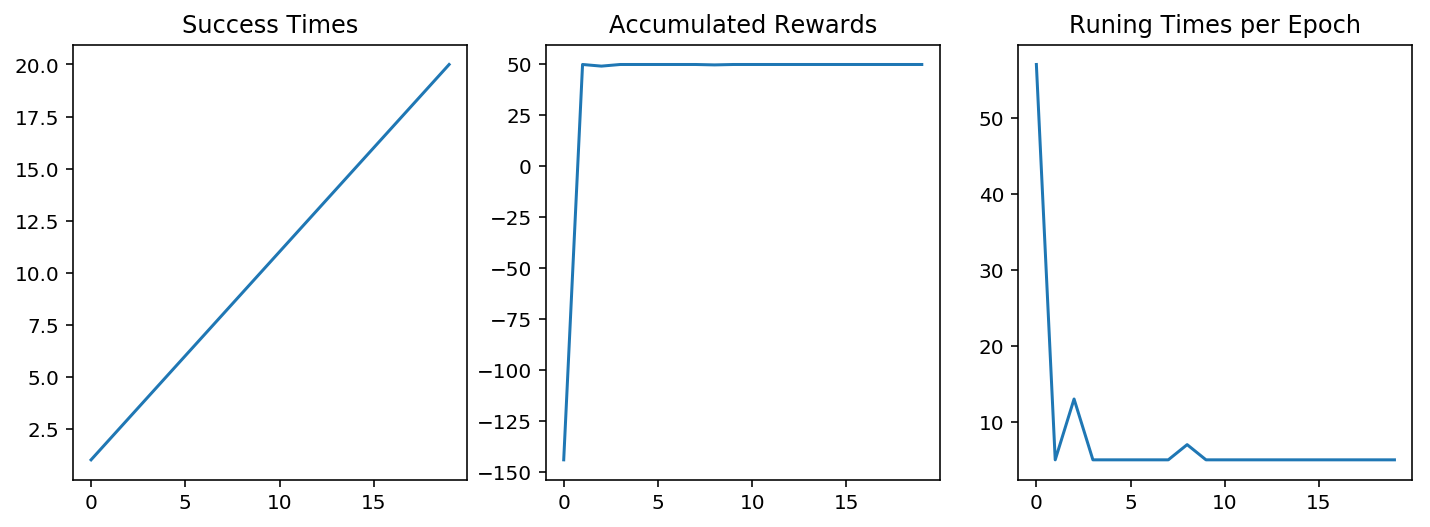

In [62]:
runner.plot_results()

(回答区)

（1）

epsilon0=0.3,设置较小的数，使得初始状态时候能随机获得更多的状态

alpha =0.6，alpha 值（0.1）太小时候，学习效果不好，过程收敛慢，alpha（0.9）太大时候，过于看重过去的回馈奖励，不利于学习新的环境

gamma = 0.9 gamma 的值接近于1 ，有利于学习反馈的效果，不然学习效果不好 收敛慢


（2）

A :调参过程中 对比了 alpha=0.1 和 alpha=0.9 及0.6 的情况，alpha=0.1 时候 学习效率慢，波动相对来说有点大， 而alpha=0.9时候，学习速度很快，epoch 没几次就学会了，但这种情况是 过于看重过去的回馈奖励，不利于学习新的环境，因此取了中间的值。

B:此外 还对比了 gamma=0.9 和gamma=0.1 的情况，gamma=0.9 时候 情况比较正常，趋于稳定，gamma=0.1 时候 波动特别大，学习效果特别不好

(3) 

对于学习效果基本满意，现在学习算法中 epsilon 的衰减是线性的，以后可以尝试一下 非线性衰减的情况



---

**问题 9：** 请将如下的文件打包，提交文件给审阅者。

- `robot.py`
- `robot_maze.ipynb`
- 由 `robot_maze.ipynb` 导出的 `robot_maze.html`